   Unnamed: 0    state  Year  cost_per_pack  sales_per_capita  tax_dollar  \
0           0  Alabama  1970          0.427              89.8         0.2   
1           1  Alabama  1971          0.423              95.4         0.2   
2           2  Alabama  1972          0.421             101.1         0.2   
3           3  Alabama  1973          0.431             102.9         0.2   
4           4  Alabama  1974          0.466             108.2         0.2   

   tax_percent  tax_revenue  tax_state      index  price_cpi  
0         46.8   36739131.0       0.12  38.825000   2.397579  
1         47.3   39490694.0       0.12  40.491667   2.277357  
2         47.5   42198422.0       0.12  41.816667   2.194771  
3         46.4   43328876.0       0.12  44.400000   2.116171  
4         42.9   45943402.0       0.12  49.308333   2.060260  


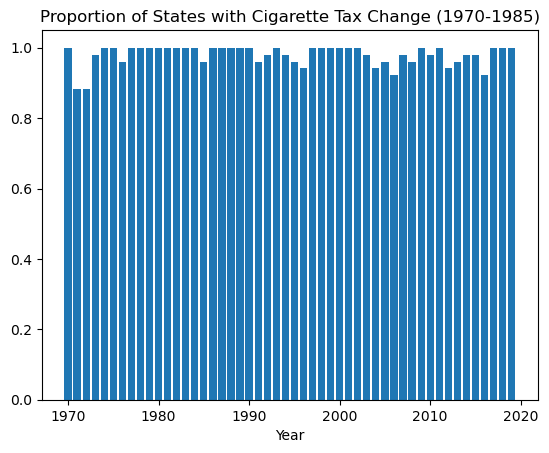

In [14]:
#summarize data
#import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load data
data = pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW3/data/output/tax_data.csv')
#show head
print(data.head())

#Present a bar graph showing the proportion of states with a change in their cigarette tax in each year from 1970 to 1985.
data = data.sort_values(by=['state', 'Year'])
data['tax_change'] = data.groupby('state')['tax_percent'].diff().ne(0).astype(int)
tax_change_proportion = data.groupby('Year')['tax_change'].mean()
# print(tax_change_proportion)
plt.bar(tax_change_proportion.index, tax_change_proportion.values)
plt.title('Proportion of States with Cigarette Tax Change (1970-1985)')
plt.xlabel('Year')
plt.show()
#check if all values in each state and each year are the same or not for the tax percent column



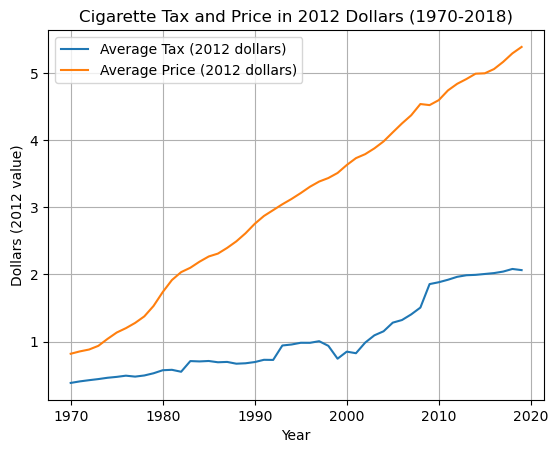

In [22]:
cpi_2012 = data.loc[data['Year'] == 2012, 'price_cpi'].iloc[0]
data['tax_dollar_2012'] = data['tax_dollar'] * (cpi_2012 / data['price_cpi'])
data['price_per_pack_2012'] = data['cost_per_pack'] * (cpi_2012 / data['price_cpi'])

avg_values = data.groupby('Year')[['tax_dollar_2012', 'price_per_pack_2012']].mean()

#line graph
plt.plot(avg_values.index, avg_values['tax_dollar_2012'], label='Average Tax (2012 dollars)')
plt.plot(avg_values.index, avg_values['price_per_pack_2012'], label='Average Price (2012 dollars)')
plt.legend()
plt.title('Cigarette Tax and Price in 2012 Dollars (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Dollars (2012 value)')
plt.grid(True)
plt.show()



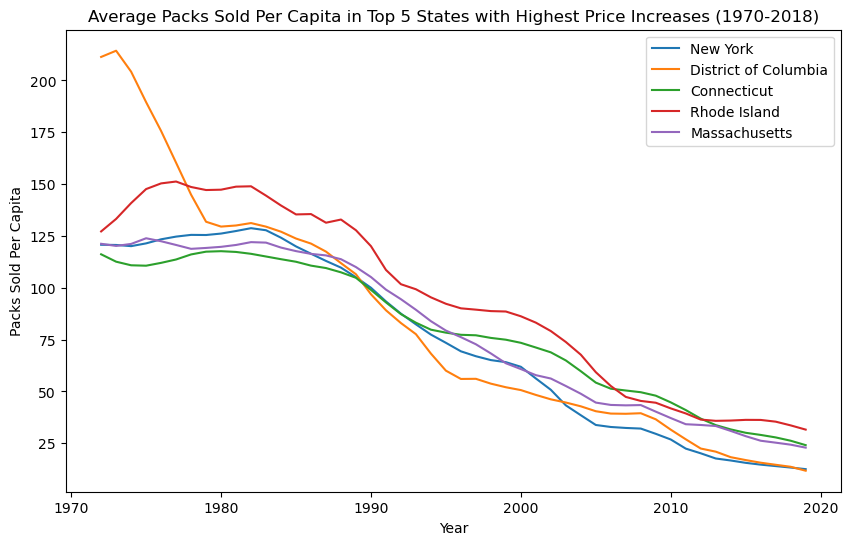

In [37]:
data_2018 = data[data['Year'] == 2018].set_index('state')
data_1970 = data[data['Year'] == 1970].set_index('state')
price_increase_by_state = data_2018['cost_per_pack'] - data_1970['cost_per_pack']

#top 5 states with the highest price increase
big_5_states = price_increase_by_state.nlargest(5).index
big_5_data = data[data['state'].isin(big_5_states)]

plt.figure(figsize=(10, 6))
for state in big_5_states:
    state_data = big_5_data[big_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state)

plt.title('Average Packs Sold Per Capita in Top 5 States with Highest Price Increases (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.show()

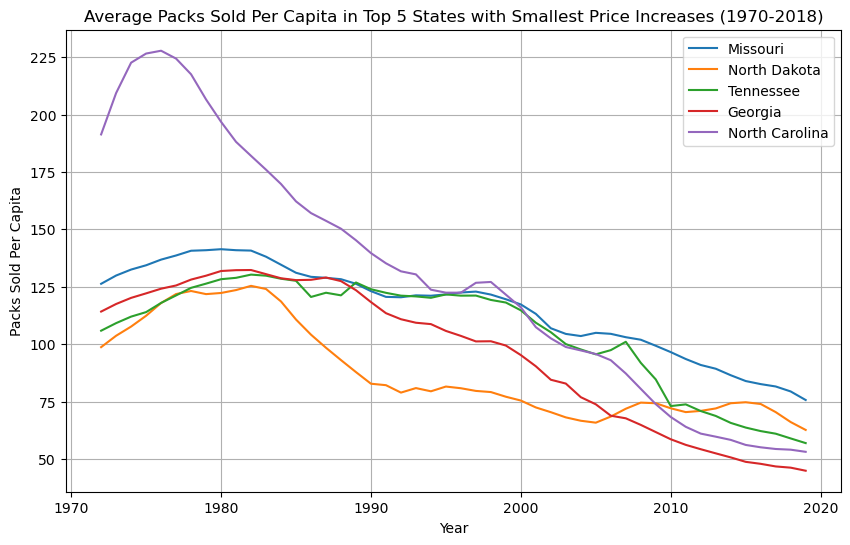

In [39]:
# Top 5 states with the smallest price increase
small_5_states = price_increase_by_state.nsmallest(5).index
small_5_data = data[data['state'].isin(small_5_states)]

plt.figure(figsize=(10, 6))
for state in small_5_states:
    state_data = small_5_data[small_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state)

plt.title('Average Packs Sold Per Capita in Top 5 States with Smallest Price Increases (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True)
plt.show()

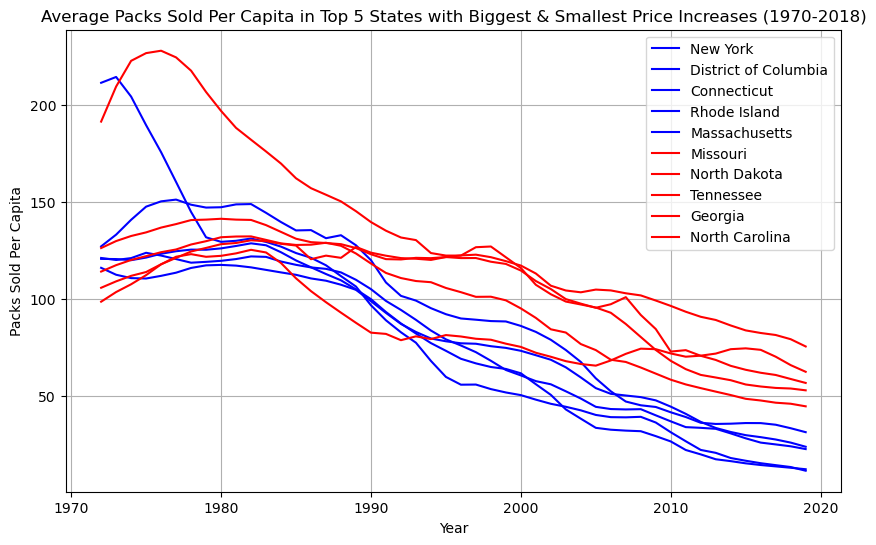

In [43]:
#overlay the two graphs and make all lines of one graph the same color
plt.figure(figsize=(10, 6))
for state in big_5_states:
    state_data = big_5_data[big_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state, color='blue')
for state in small_5_states:
    state_data = small_5_data[small_5_data['state'] == state]
    plt.plot(state_data['Year'], state_data['sales_per_capita'].rolling(window=3).mean(), label=state, color='red')
plt.title('Average Packs Sold Per Capita in Top 5 States with Biggest & Smallest Price Increases (1970-2018)')
plt.xlabel('Year')
plt.ylabel('Packs Sold Per Capita')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# both start with similar sales per capita, but the states with the highest price increases have a steeper decline in sales per capita compared to the states with the smallest price increases. This suggests that significant price increases do decrease cigarette sales per capita further. 